In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az

In [3]:
%matplotlib inline

In [4]:
consolidated = pd.read_csv('./BattingAverage.csv')
consolidated.drop(columns=['Player', 'PriPos'], inplace=True)
consolidated.rename(columns={'Hits': 'successes', 'AtBats': 'attempts', 'PlayerNumber': 'individual_id', 'PriPosNumber': 'category_id'}, inplace=True)

min_category_id = np.min(consolidated['category_id'])
min_individual_id = np.min(consolidated['individual_id'])

consolidated['category_id'] = consolidated['category_id'] - min_category_id
consolidated['individual_id'] = consolidated['individual_id'] - min_individual_id
consolidated.head()

successes  attempts  individual_id  category_id
0          1         7              0            0
1         53       219              1            6
2         18        70              2            3
3        137       607              3            3
4         21        86              4            2

In [5]:
num_individuals = len(consolidated)
num_categories = len(np.unique(consolidated['category_id']))

print('num_individuals', num_individuals, 'num_categories', num_categories)

individual_id = consolidated['individual_id']
category_id = consolidated['category_id']


num_individuals 948 num_categories 9


## Heirarchy with Overall

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_individual, concentration_category, p_category, concentration_overall, p_overall]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:59<00:00, 167.64draws/s]
The number of effective samples is smaller than 25% for some parameters.


                         mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  \
p_overall               0.251  0.034   0.190    0.316      0.000    0.000   
concentration_overall  19.385  6.493   7.928   31.835      0.062    0.044   
p_category[0]           0.131  0.007   0.118    0.143      0.000    0.000   
p_category[1]           0.239  0.008   0.224    0.253      0.000    0.000   
p_category[2]           0.252  0.008   0.236    0.266      0.000    0.000   
...                       ...    ...     ...      ...        ...      ...   
p_individual[943]       0.143  0.056   0.046    0.248      0.001    0.000   
p_individual[944]       0.280  0.018   0.247    0.313      0.000    0.000   
p_individual[945]       0.169  0.040   0.096    0.242      0.000    0.000   
p_individual[946]       0.097  0.032   0.038    0.154      0.000    0.000   
p_individual[947]       0.269  0.018   0.234    0.303      0.000    0.000   

                       ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
p_ove

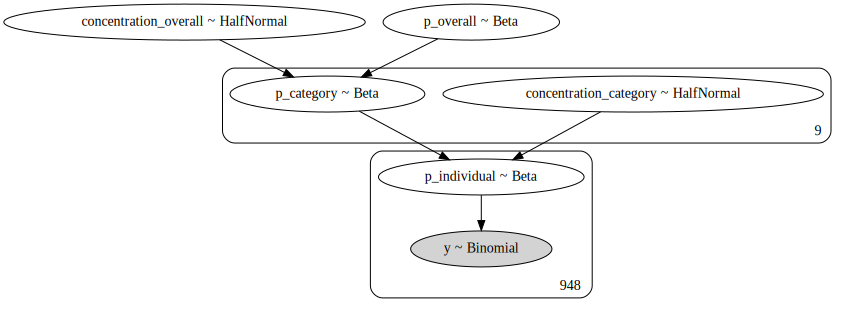

In [6]:
with pm.Model() as model_h_o:
  p_overall = pm.Beta('p_overall', 1, 1)
  concentration_overall = pm.HalfNormal('concentration_overall', 10)


  p_category = pm.Beta('p_category',
                       alpha=p_overall*concentration_overall,
                       beta=(1.0-p_overall)*concentration_overall,
                       shape=num_categories)
  concentration_category = pm.HalfNormal('concentration_category', 10, shape=num_categories)

  p_individual = pm.Beta('p_individual',
                       alpha=p_category[category_id]*concentration_category[category_id],
                       beta=(1.0-p_category[category_id])*concentration_category[category_id],
                       shape=num_individuals)

  y = pm.Binomial('y', n=consolidated['attempts'], p=p_individual[individual_id], observed=consolidated['successes']) # likelihood p(y|θ)

  trace_h_o = pm.sample(2000)
  print(az.summary(trace_h_o))

pm.model_to_graphviz(model_h_o)

In [7]:
raw = pd.read_csv('./BattingAverage.csv')
raw.drop(columns=['Player', 'Hits', 'AtBats', 'PlayerNumber'], inplace=True)
raw.drop_duplicates(inplace=True)
raw.sort_values(by='PriPosNumber', inplace=True)
positions = raw['PriPos'].to_numpy()
print(positions)


raw = pd.read_csv('./BattingAverage.csv')
raw.drop(columns=['PriPos', 'PriPosNumber', 'Hits', 'AtBats'], inplace=True)
raw.drop_duplicates(inplace=True)
raw.sort_values(by='PlayerNumber', inplace=True)
players = raw['Player'].to_numpy()

['Pitcher' 'Catcher' '1st Base' '2nd Base' '3rd Base' 'Shortstop'
 'Left Field' 'Center Field' 'Right Field']


In [8]:
data_h_o = az.from_pymc3(
    trace=trace_h_o,
    # prior=prior,
    # posterior_predictive=posterior_predictive,
    model=model_h_o,
    coords={'category': positions, 'individual': players},
    dims={'p_category': ['category'], 'p_individual': ['individual']},
)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f754de89940>],
      dtype=object)

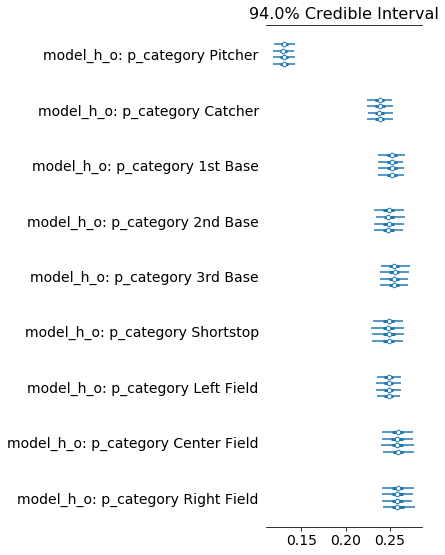

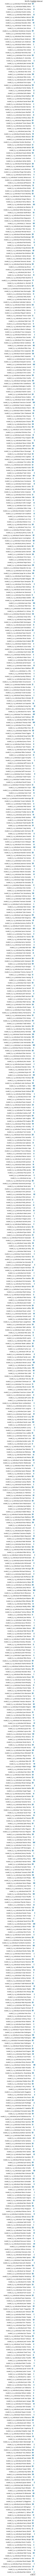

In [9]:
az.plot_forest(data_h_o, model_names=['model_h_o'], var_names='p_category')
az.plot_forest(data_h_o, model_names=['model_h_o'], var_names='p_individual')

In [10]:
mid_point = trace_h_o['p_overall'].mean()
mid_point = round(mid_point, 2)
left_point = round(mid_point-mid_point*0.1, 2)
right_point = round(mid_point+mid_point*0.1, 2)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f75303aeb00>,
      dtype=object)

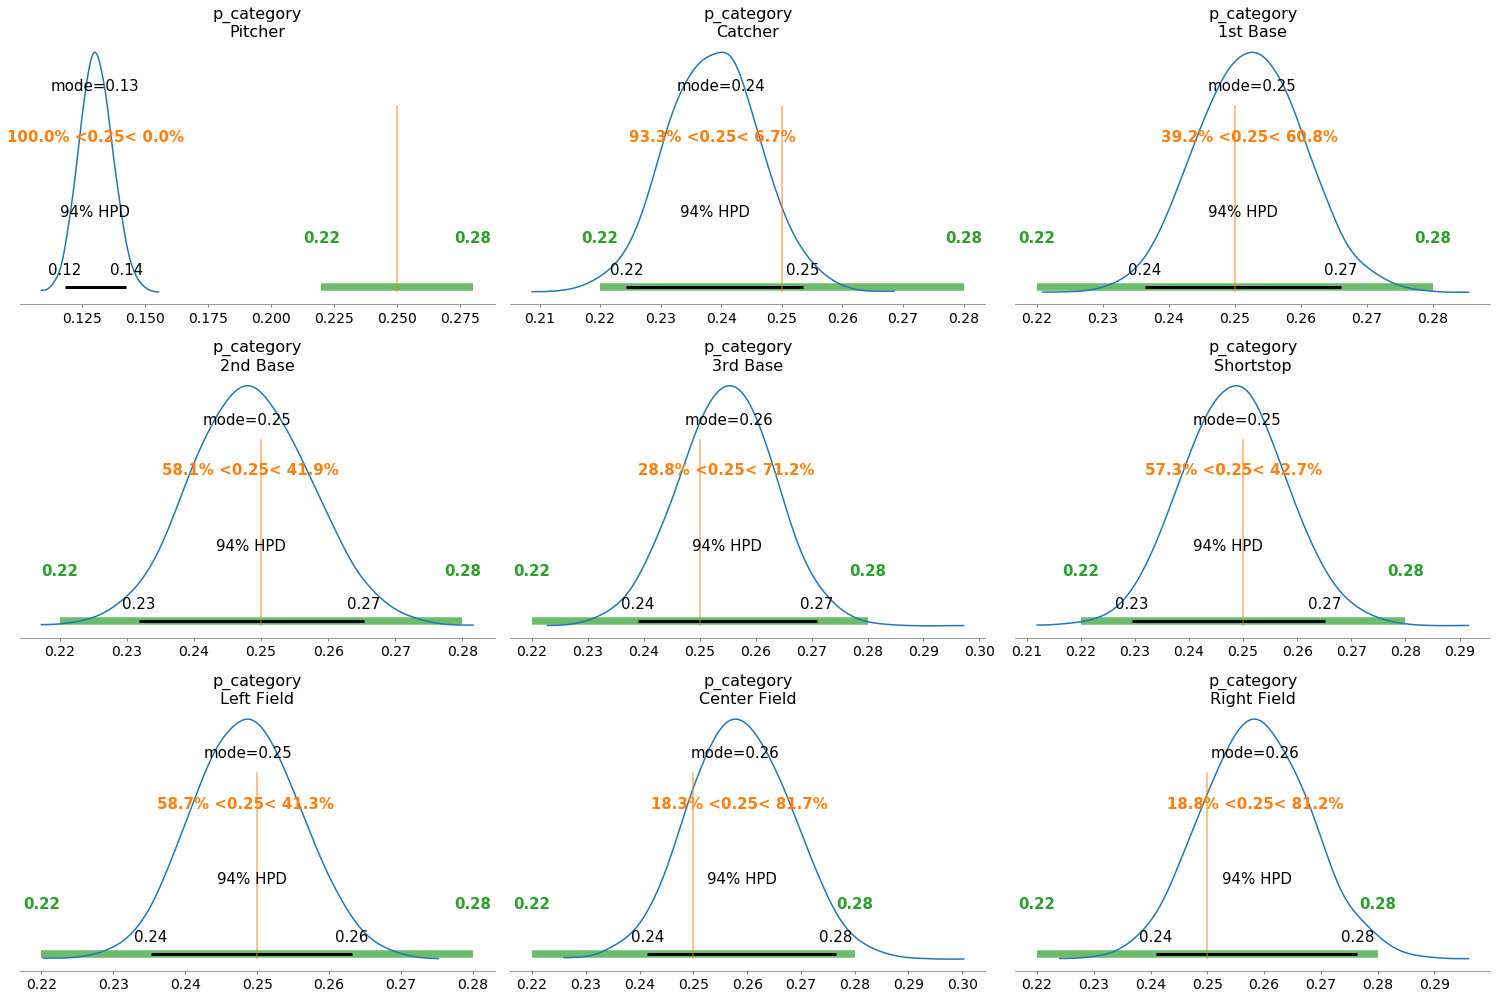

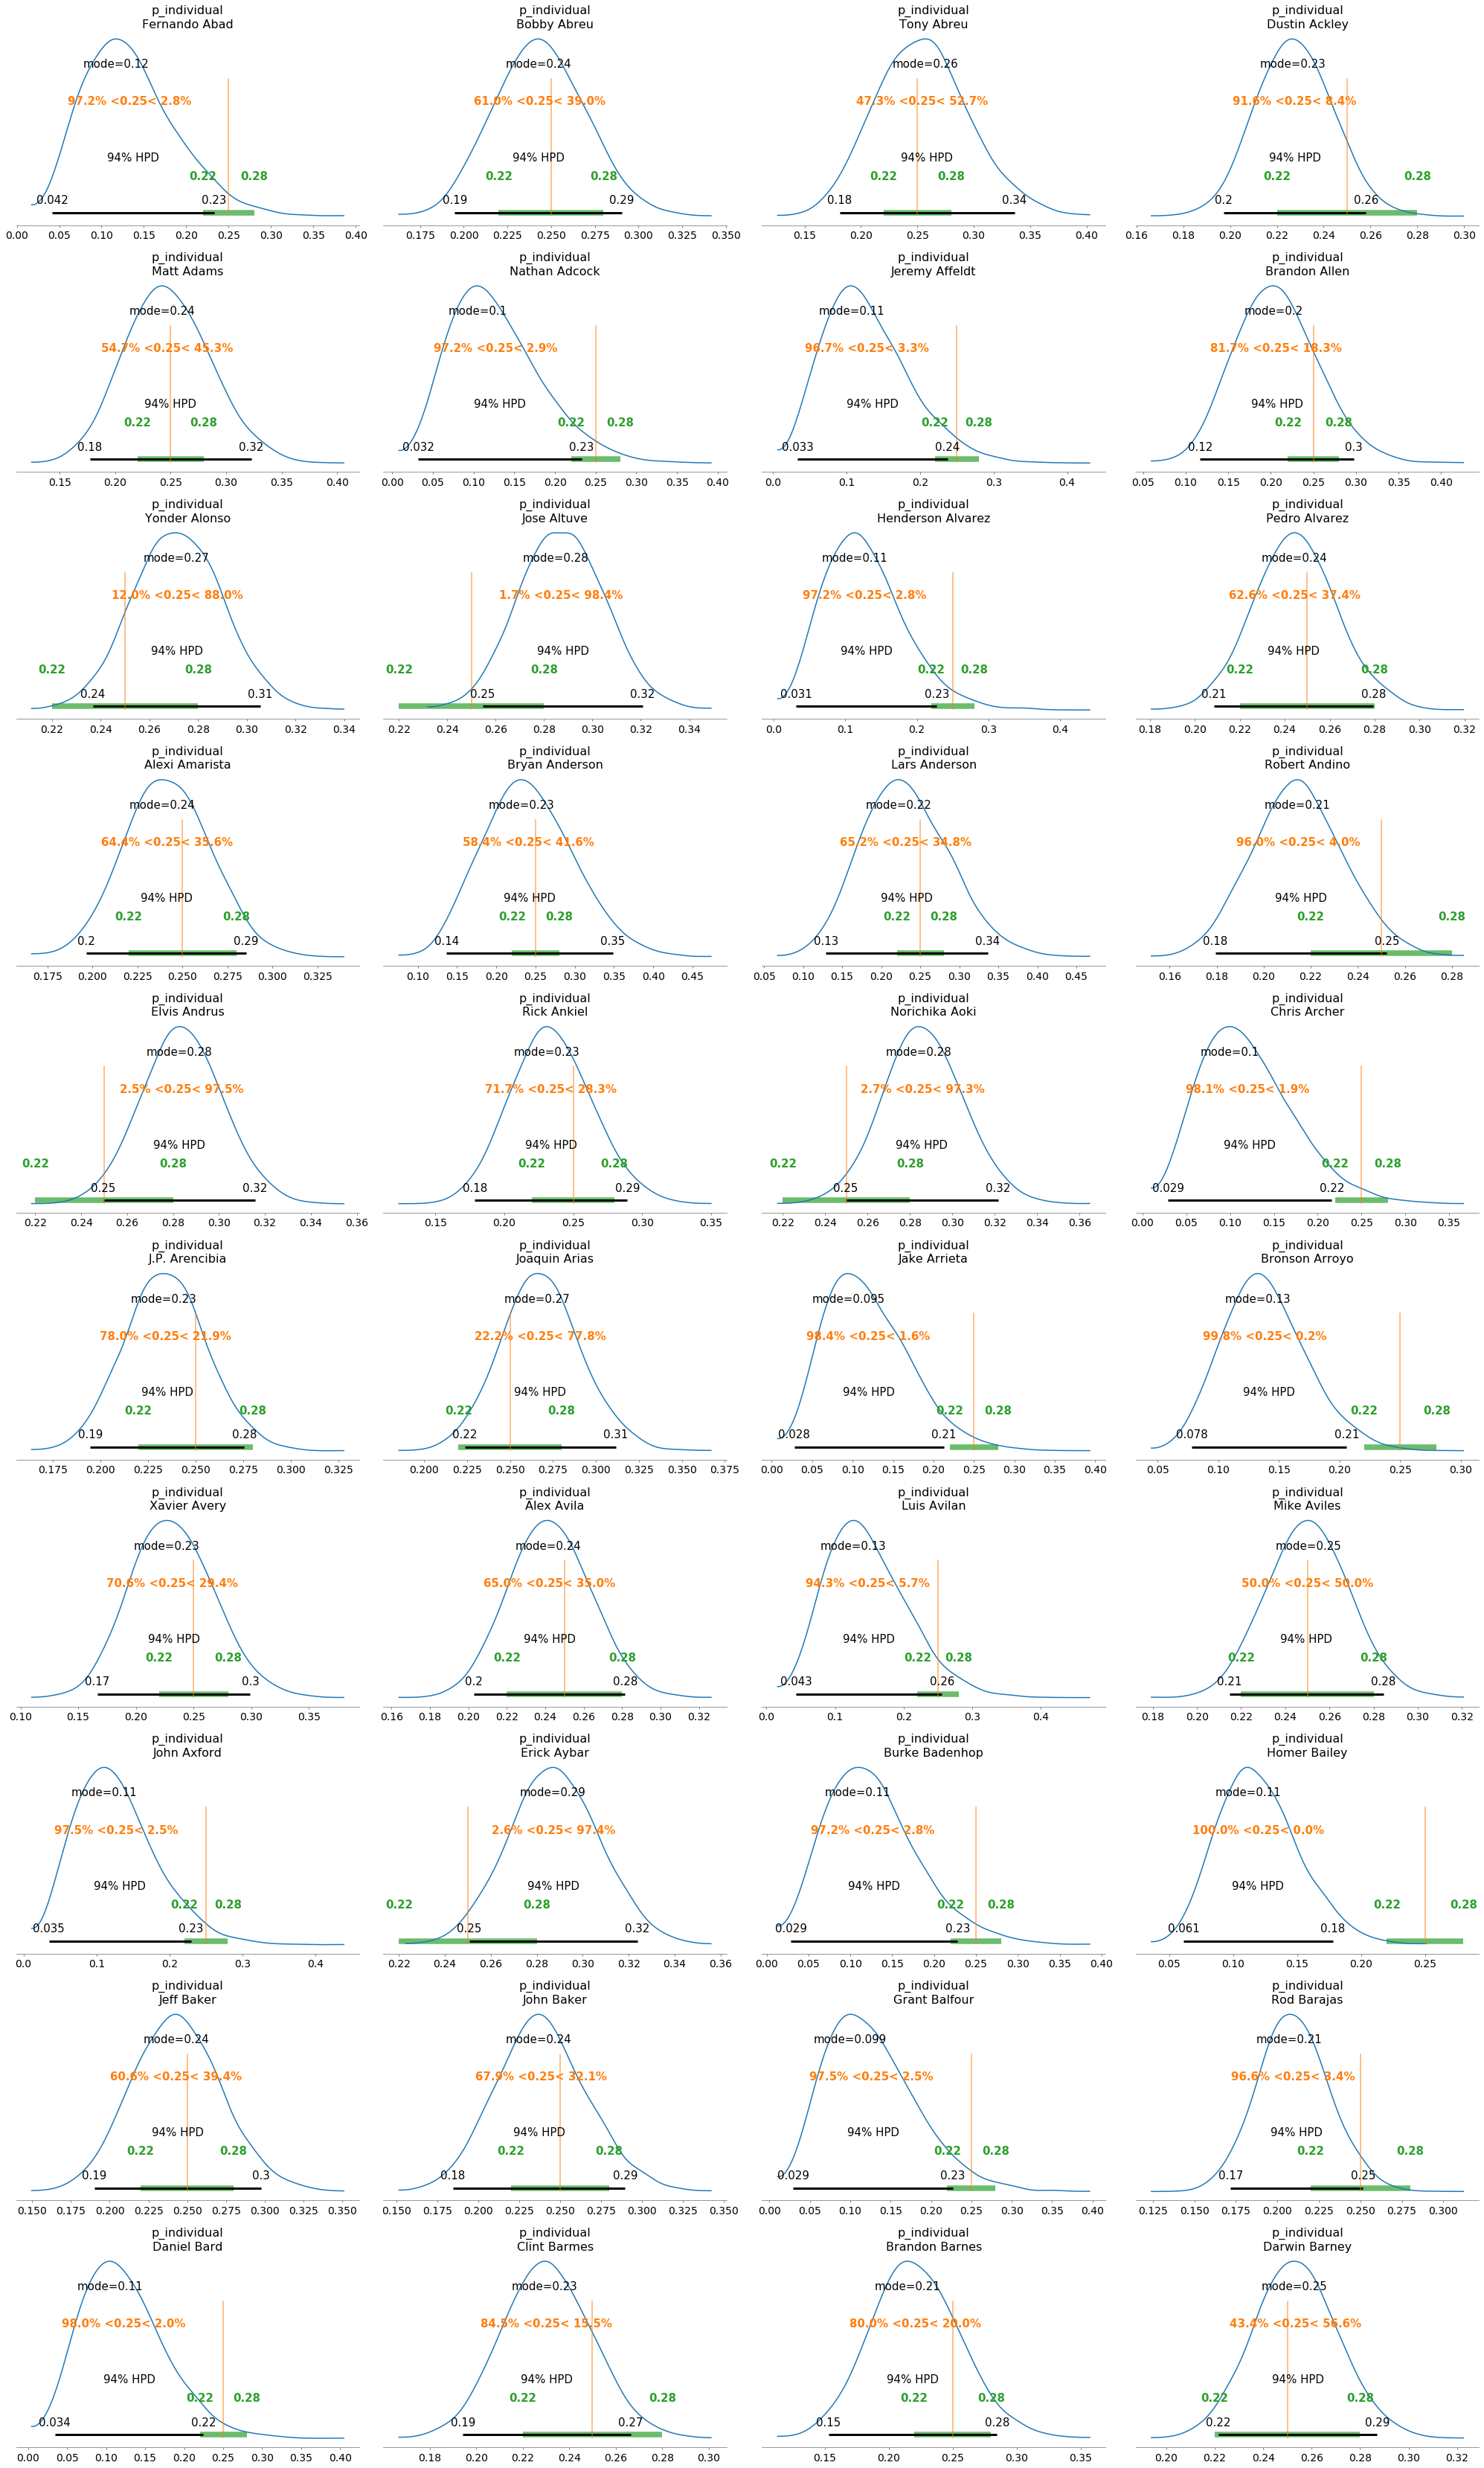

In [11]:
az.plot_posterior(data_h_o, rope=[left_point, right_point], ref_val=mid_point, point_estimate='mode', var_names='p_category')
az.plot_posterior(data_h_o, rope=[left_point, right_point], ref_val=mid_point, point_estimate='mode', var_names='p_individual')